In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import utils

In [2]:
prefixes = [
    #'../retrieval_outputs/no_bands_K_B_ret_6/test_', 
    #'../retrieval_outputs/eq_band_K_B_ret_2/test_', 
    '../retrieval_outputs/spot_K_B_ret_19/test_', 
    ]

CCF_species = [{
    'complete': None, 
    'H2O': 'H2O_pokazatel_main_iso', 
    'CO': 'CO_main_iso', 
    'CH4': 'CH4_hargreaves_main_iso', 
    #'NH3': 'NH3_coles_main_iso', 
    }]*len(prefixes)

for i, prefix_i in enumerate(prefixes):

    Res_i = utils.RetrievalResults(prefix=prefix_i)

    for key_j, line_species_j in CCF_species[i].items():

        print(f'{i} | {key_j}')

        flux_global = None
        subtract_global = False

        if line_species_j is None:
            # Get the global model spectrum
            _, flux_global, Rot_i = Res_i.get_model_spec(is_local=False)
            subtract_global = True

        # Template spectrum of one species
        wave_local, flux_local, _ = Res_i.get_model_spec(
            is_local=True, line_species=line_species_j
            )
        # Compute cross-correlation
        rv, _, CCF_SNR = Res_i.get_CCF(
            wave_local, flux_local, flux_global, subtract_global=subtract_global, 
            )
        CCF_species[i][key_j] = CCF_SNR

        del wave_local, flux_local, flux_global

  analysing data from ../retrieval_outputs/spot_K_B_ret_19/test_.txt
0 | complete


100%|██████████| 1201/1201 [00:05<00:00, 238.92it/s]


0 | H2O


100%|██████████| 1201/1201 [00:04<00:00, 246.41it/s]


0 | CO


100%|██████████| 1201/1201 [00:04<00:00, 245.14it/s]


0 | CH4


100%|██████████| 1201/1201 [00:04<00:00, 251.16it/s]


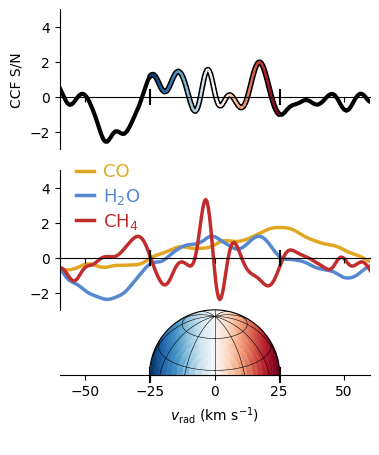

In [14]:
i = 0
vsini_i = Res_i.bestfit_params['K2166_cloudy']['vsini']

ylims = [(-3,5), (-3,5)]
y_offset = 0.04

fig = plt.figure(figsize=(4,6))
gs = fig.add_gridspec(nrows=3, ncols=1, hspace=0.15, wspace=0., height_ratios=[1,1,1])
ax_CCF = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[1,0]), 
    ])

for ax_CCF_i in ax_CCF:
    # Set x-axis to y=0
    ax_CCF_i.spines[['bottom']].set_position('zero')
    ax_CCF_i.spines[['bottom']].set_zorder(3)
    ax_CCF_i.set(xticks=np.arange(-100,101,25), xticklabels=[])

ylabel = 'CCF S/N'
CC = utils.CrossCorrPlot(fig, ax_CCF[0], vsini=vsini_i)
CC.plot(rv, CCF_species[i]['complete'], lw=3, c='k', plot_colorbar=False, zorder=-1)
CC.configure_ax(ylabel=ylabel, ylim=ylims[0], xlabel=None, xlim=(-60,60), plot_axvline=False)
CC.add_xtick_at_vsini(length=0.1)

ylabel = None
CC = utils.CrossCorrPlot(fig, ax_CCF[1], vsini=vsini_i)
CC.plot(rv, CCF_species[i]['CO'], lw=2.5, c=utils.get_color(4), plot_multicolor=False, label='CO', zorder=-1)
CC.plot(rv, CCF_species[i]['H2O'], lw=2.5, c=utils.get_color(3), plot_multicolor=False, label=r'H$_2$O', zorder=-1)
CC.plot(rv, CCF_species[i]['CH4'], lw=2.5, c=utils.get_color(2), plot_multicolor=False, label=r'CH$_4$', zorder=-1)
CC.configure_ax(ylabel=ylabel, ylim=ylims[1], xlabel=None, xlim=(-60,60), plot_axvline=False)
CC.add_xtick_at_vsini(length=0.1)

ax_CCF[-1].legend(
    loc='upper left', bbox_to_anchor=(0,1.17), frameon=False, 
    labelcolor=[utils.get_color(4),utils.get_color(3),utils.get_color(2)], fontsize=13, 
    handlelength=1, labelspacing=0.3, handletextpad=0.5
    )

# Plot the half-sphere at the bottom of the figure
ax_bottom = np.array([
    fig.add_subplot(gs[2,0], projection='polar'), 
    fig.add_subplot(gs[2,0], zorder=-1), 
    ])

sphere = utils.SpherePlot(Rot_i, fig, ax_bottom[0])
sphere.plot_map(
    attr='v_grid', cmap='RdBu_r', edgecolors='face', lw=1e-6, 
    )
sphere.configure_ax(
    xlim=(0,np.pi), sep_spine_lw=None, grid_lw=0.4
    )

# Determine the vsini-width in one of the cross-correlation axes
vsini_width, _ = np.diff(
    fig.transFigure.inverted().transform(
        ax_CCF[-1].transData.transform([(-vsini_i,0),(vsini_i,0)])
        ), 
    axis=0
    ).flatten()

ax_bottom[-1].set(yticks=[], facecolor='none')
ax_bottom[-1].spines[['left','top','right']].set_visible(False)
ax_bottom[-1].spines[['bottom']].set_position('zero')

# Change the width of the half-sphere axis
l, b, w, h = ax_bottom[0].get_position().bounds
ax_bottom[0].set_position([
    l+w/2-vsini_width/2, b+y_offset, vsini_width, h
    ])
ax_bottom[0].get_position() # Update

# Shift the x-axis so it touches the half-sphere
ylim = ax_CCF[-1].get_ylim()
h = np.abs(ylim[1] - ylim[0])
ax_bottom[-1].set(ylim=(-h/2,h/2))

xy0 = fig.transFigure.inverted().transform(ax_bottom[0].transData.transform((0,0)))
xy1 = fig.transFigure.inverted().transform(ax_bottom[-1].transData.transform((0,0)))
dy = xy0[1] - xy1[1]

l, b, w, h = ax_bottom[-1].get_position().bounds
ax_bottom[-1].set_position([
    l, b+dy, w, h
    ])

CC = utils.CrossCorrPlot(fig, ax_bottom[-1], vsini=vsini_i)
CC.plot(rv, CCF_species[i]['CO']*np.nan, plot_multicolor=False)
CC.configure_ax(ylim=(-h/2,h/2), xlabel=None, plot_axvline=False)
CC.add_xtick_at_vsini(length=0.1)

ax_bottom[-1].set(
    xticks=np.arange(-100,101,25), xlim=ax_CCF[-1].get_xlim(),
    xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
    )

#for ax_i in ax_CCF+[ax_bottom[-1]]:
#    y = CC.add_xtick_at_vsini(length=0.08, return_ticks=True)
#    ax_i.plot([-CC.vsini]*2, y, c='k', lw=0.8, clip_on=False)
#    ax_i.plot([+CC.vsini]*2, y, c='k', lw=0.8, clip_on=False)

# Create a tighter bounding box to save the figure
l, b, *_ = ax_bottom[-1].get_position().bounds
r = ax_bottom[-1].get_position().bounds[0] + ax_bottom[-1].get_position().bounds[2]
t = ax_CCF[0].get_position().bounds[1] + ax_CCF[0].get_position().bounds[3]

l, r, b, t = np.array([l, r, b, t]) + np.array([-0.17,0.03,0.02,0.03])

l, r = np.array([l, r]) * fig.get_size_inches()[0]
b, t = np.array([b, t]) * fig.get_size_inches()[1]
bbox = mpl.transforms.Bbox([[l,b],[r,t]])

plt.savefig('./plots/chem_cross_corr.pdf', bbox_inches=bbox)
plt.show()